## ***PSET 4 - Locating cars' tire***

**Loading packages**

In [1]:
!pip install -Uqq torch==1.7.1
!pip install -Uqq fastai --upgrade
!pip install -Uqq fastcore --upgrade

In [2]:
import fastai
import fastcore
print('Fast.ai version:', fastai.__version__)
print('Fastcore version:', fastcore.__version__)

Fast.ai version: 2.3.0
Fastcore version: 1.3.19


In [3]:
from fastai.vision.all import *

In [4]:
!nvidia-smi

Thu Apr  8 20:24:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get image files

In [5]:

%cd "/content/drive/MyDrive/Colab Notebooks/PSET4"

/content/drive/MyDrive/Colab Notebooks/PSET4


In [6]:
%ls

PSET4.ipynb  unegui_car_labels.json  unegui_cars@


In [7]:
path = Path('unegui_cars')

In [8]:
path

Path('unegui_cars')

In [9]:
img_files = get_image_files(path)

In [10]:
img_files[0]

Path('unegui_cars/93_toyota_camry_2009_2018_6.jpg')

In [11]:
im = PILImage.create(img_files[1])
im.shape

(451, 600)

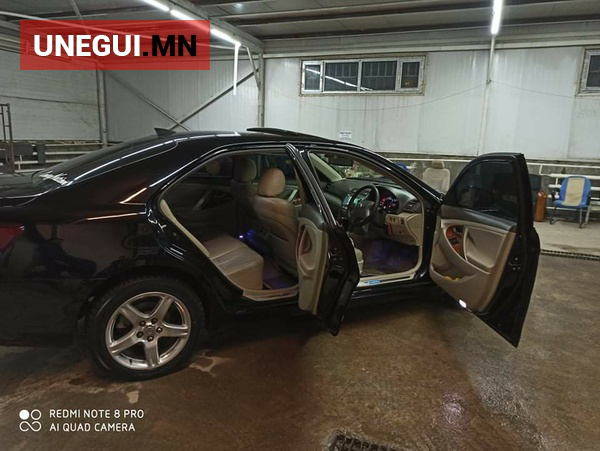

In [12]:
im.to_thumb(600)

## Extract useful variables from json file

In [13]:
json_file = pd.read_json("unegui_car_labels.json")
json_file.head()

,ID,DataRow ID,Labeled Data,Label,Created By,Project Name,Created At,Updated At,Seconds to Label,External ID,Agreement,Benchmark Agreement,Benchmark ID,Dataset Name,Reviews,View Label,Has Open Issues
0,cklss3vqy00023g65nljtomwk,ckls7302z9pi40rb6hs1ygj0f,https://storage.labelbox.com/cklf80b0num520795r9ounh7m%2F3bffcd27-218d-6b23-dcf8-6f4628cab6d2-2_lexus_rx_2013_2021_9.jpg?Expires=1617880747159&KeyName=labelbox-assets-key-1&Signature=7MRRMvcJ6mEHNmGtrXQtw3N_eBY,"{'objects': [], 'classifications': [{'featureId': 'cklss3uko00013g65t9rqy83k', 'schemaId': 'cklsrpbhs0c190y8db0zefv9q', 'title': 'Which side is the car facing?', 'value': 'which_side_is_the_car_facing?', 'answer': {'featureId': 'cklss3uko00003g65dfux3zcf', 'schemaId': 'cklsrpbib0c1b0y8dhjpudt0k', 'title': 'NotCar', 'value': 'notcar'}}]}",robertritz@ider.edu.mn,Mongolia Car Classification,2021-03-03T01:46:14.000Z,2021-03-13T11:30:09.000Z,27.468,2_lexus_rx_2013_2021_9.jpg,1.0,-1,NaN,Mongolia Car Classification Dataset,[],https://editor.labelbox.com?project=cklrzb2rn3e0307956sbdzpa7&label=cklss3vqy00023g65nljtomwk,0
1,cklss4pco00033g65oom4w94a,ckls7303r9rvg0rb6cizda2r4,https://storage.labelbox.com/cklf80b0num520795r9ounh7m%2Fc8a5ec1e-9951-a2a9-4132-80e1310a78ea-4_toyota_alphard_2009_2019_2.jpg?Expires=1617880747159&KeyName=labelbox-assets-key-1&Signature=4GMyBKsPmWya30Ib_Y9xCQwk0Oo,{},robertritz@ider.edu.mn,Mongolia Car Classification,2021-03-03T01:46:53.000Z,2021-03-03T01:47:24.000Z,10.011,4_toyota_alphard_2009_2019_2.jpg,-1.0,-1,NaN,Mongolia Car Classification Dataset,[],https://editor.labelbox.com?project=cklrzb2rn3e0307956sbdzpa7&label=cklss4pco00033g65oom4w94a,0
2,cklss5j6j00063g650lb678k4,ckls7304j9svc0rb62ern0xw2,https://storage.labelbox.com/cklf80b0num520795r9ounh7m%2Ff062f01a-b6b6-149c-07d0-83b0e1a6ca8c-5_kia_%D0%B1%D1%83%D1%81%D0%B0%D0%B4_2007_2020_0.jpg?Expires=1617880747159&KeyName=labelbox-assets-key-1&Signature=vJioeO9LcW0gBHpKG6Zh0XHU87U,"{'objects': [], 'classifications': [{'featureId': 'cklss5i2z00053g658487qjzy', 'schemaId': 'cklsrpbhs0c190y8db0zefv9q', 'title': 'Which side is the car facing?', 'value': 'which_side_is_the_car_facing?', 'answer': {'featureId': 'cklss5i2z00043g654skvx0dh', 'schemaId': 'cklsrpbib0c1d0y8d7syvdobs', 'title': 'Front', 'value': 'front'}}]}",robertritz@ider.edu.mn,Mongolia Car Classification,2021-03-03T01:47:31.000Z,2021-03-13T10:37:56.000Z,30.048,5_kia_бусад_2007_2020_0.jpg,1.0,-1,NaN,Mongolia Car Classification Dataset,[],https://editor.labelbox.com?project=cklrzb2rn3e0307956sbdzpa7&label=cklss5j6j00063g650lb678k4,0
3,cklss5taq00093g65go5puz2x,ckls730309plo0rb6eyzx5j3e,https://storage.labelbox.com/cklf80b0num520795r9ounh7m%2Fe4464ba2-fcbf-5833-1e8c-0faf9031b51c-2_subaru_forester_2012_2021_9.jpg?Expires=1617880747159&KeyName=labelbox-assets-key-1&Signature=vTiGEygIXeZzFPXhaJyAOd5Th20,"{'objects': [], 'classifications': [{'featureId': 'cklss5s9300083g65hki2aolc', 'schemaId': 'cklsrpbhs0c190y8db0zefv9q', 'title': 'Which side is the car facing?', 'value': 'which_side_is_the_car_facing?', 'answer': {'featureId': 'cklss5s9300073g65ipivezh6', 'schemaId': 'cklsrpbic0c1j0y8d74rl6zhl', 'title': 'Interior', 'value': 'interior'}}]}",robertritz@ider.edu.mn,Mongolia Car Classification,2021-03-03T01:47:44.000Z,2021-03-13T11:31:50.111Z,10.004,2_subaru_forester_2012_2021_9.jpg,0.0,-1,NaN,Mongolia Car Classification Dataset,[],https://editor.labelbox.com?project=cklrzb2rn3e0307956sbdzpa7&label=cklss5taq00093g65go5puz2x,0
4,cklss8df500003g65phw2872n,ckls7303s9rz00rb67ckv1ylf,https://storage.labelbox.com/cklf80b0num520795r9ounh7m%2F8434b698-cc86-2b08-4105-11dbcf34f35c-4_toyota_camry_2008_2013_1.jpg?Expires=1617880747160&KeyName=labelbox-assets-key-1&Signature=NfRZt0p4scZGT21mN-T3nsjupEk,"{'objects': [], 'classifications': [{'featureId': 'cklss7jz900013g68v05xqlhh', 'schemaId': 'cklsrpbhs0c190y8db0zefv9q', 'title': 'Which side is the car facing?', 'value': 'which_side_is_the_car_facing?', 'answer': {'featureId': 'cklss7jz900003g68eq28d7tm', 'schema

Seems like we only need "Label" & "External ID" columns

In [14]:
for col in json_file.columns:
    print(col)

ID
DataRow ID
Labeled Data
Label
Created By
Project Name
Created At
Updated At
Seconds to Label
External ID
Agreement
Benchmark Agreement
Benchmark ID
Dataset Name
Reviews
View Label
Has Open Issues


In [15]:
i_x_y = pd.DataFrame(columns=["img_name", 'x', 'y'])

In [16]:
for i,r in json_file.iterrows():
  label = r['Label']
  id = r['External ID']
  if 'objects' not in label.keys():
    continue

  for json in label['objects']:
    if json['title'] == 'Tire':
      points = tensor([int(json['point']['x']),
                      int(json['point']['y'])])
      x = points.numpy()[0]
      y = points.numpy()[1]
      
      
      i_x_y = i_x_y.append({'img_name': id,
                            'x': x,
                            'y':y},
      ignore_index=True)
                         

In [17]:
i_x_y

,img_name,x,y
0,5_mitsubishi_delica_2005_2015_2.jpg,386,352
1,5_mitsubishi_delica_2005_2015_2.jpg,514,273
2,5_mitsubishi_delica_2005_2015_2.jpg,121,347
3,2_toyota_aqua_2014_2021_2.jpg,243,312
4,2_toyota_aqua_2014_2021_2.jpg,129,186
...,...,...,...
8179,23_toyota_aqua_2012_2021_1.jpg,245,337
8180,11_toyota_prius_30_2010_2019_3.jpg,246,431
8181,11_toyota_prius_30_2010_2019_3.jpg,83,293
8182,20_toyota_hilux_2008_2017_0.jpg,93,262


## Building DataLoaders and DataBlock

In [18]:
def get_y(r):
  return tensor([r['x'],r['y']])

def get_x(r):
  fname = str(r['img_name'])
  return '/content/drive/MyDrive/Colab Notebooks/PSET4/unegui_cars/' + fname

In [19]:
data = DataBlock(blocks=(ImageBlock, PointBlock),
                 splitter  =RandomSplitter(valid_pct=0.2, seed=42),
                 get_x     =get_x,
                 get_y     =get_y,
                 item_tfms = Resize((600,850),method='pad'))
                 


In [20]:
data

In [21]:
dls = data.dataloaders(i_x_y, batch_size = 16)

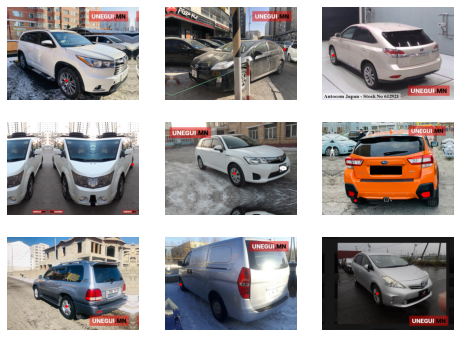

In [22]:
dls.show_batch(max_n=9, figsize=(8,6))

## Training

In [23]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([16, 3, 600, 850]), torch.Size([16, 1, 2]))

In [24]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [25]:
dls.loss_func

FlattenedLoss of MSELoss()

In [26]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.356448,0.239813,03:37


epoch,train_loss,valid_loss,time
0,0.209587,0.152257,04:22
1,0.154406,0.139214,04:23
2,0.150323,0.132667,04:23
3,0.138074,0.125918,04:22
4,0.127259,0.125358,04:22


In [28]:
math.sqrt(0.125358)

0.3540593170642456

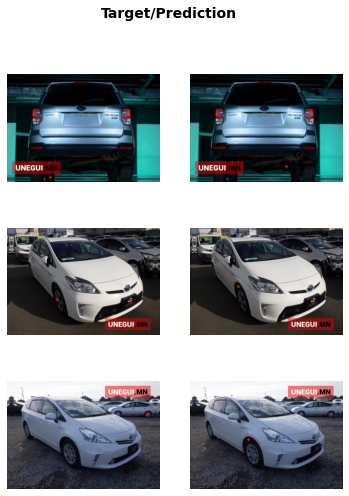

In [34]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))